In [63]:
import jax.numpy as jnp
from jax import jit, grad, vmap
import matplotlib.pyplot as plt
import numpy as np
from jax import random
from jax import jit, jacfwd, lax, jacrev, hessian

key = random.PRNGKey(0)
print(f"{key = }")

key = Array([0, 0], dtype=uint32)


In [64]:
def reference_function1(t):
    """Trajectory to track"""
    return np.array([0., 0., -3., 0.]).reshape((4,1))

def reference_function2(t):
    """Trajectory to track"""
    return np.array([np.sin(t), np.cos(t), -3., 0.]).reshape((4,1))

def reference_function3(x10, t):
    """Trajectory to track"""
    return np.array([0., 0., -(2 + np.sin(t), 0.)]).reshape((4,1))

In [65]:
reffunc = reference_function2

In [66]:
# Simulation parameters
T = 10.0  # Time Horizon of simulation
SIM_STEP = 0.1  # Time step of simulation
T_lookahead = 0.8  # Time horizon for Control
INTEGRATION_STEP = 0.1
C = jnp.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 1]])
MASS = 1.75
GRAVITY = 9.81
ref0 = reffunc(0.0+T_lookahead)

x10 = 0.0  # initial state
x20 = 0.0  # initial state
x30 = -0.2  # initial state
x40 = 0.0  # initial state
x50 = 0.0  # initial state
x60 = 0.0  # initial state
x70 = 0.0  # initial state
x80 = 0.0  # initial state
x90 = 0.0  # initial state
state0 = jnp.array([x10, x20, x30, x40, x50, x60, x70, x80, x90]).reshape((9,1))

u0_thrust = MASS * GRAVITY
u0_roll = 0.0
u0_pitch = 0.0
u0_yaw = 0.0
input0 = jnp.array([u0_thrust, u0_roll, u0_pitch, u0_yaw]).reshape((4,1))


i = 0

In [67]:
# Logs
states = np.zeros((int(T/SIM_STEP), len(state0)))
inputs = np.zeros((int(T/SIM_STEP), len(input0)))
refs = np.zeros((int(T/SIM_STEP), len(ref0)))

# log initial values
states[i] = state0.flatten().tolist()
inputs[i] = input0.flatten().tolist()
refs[i] = ref0.flatten().tolist()

In [86]:
from jax import debug

# @jit
def dynamics(state, input):
    """Compute the state derivative."""
    x, y, z, vx, vy, vz, roll, pitch, yaw = state#.flatten().tolist()
    curr_thrust, curr_rolldot, curr_pitchdot, curr_yawdot = input#.flatten().tolist()

    # print(f"{curr_thrust = }")
    # print(f"{curr_rolldot = }")
    # print(f"{curr_pitchdot = }")
    # print(f"{curr_yawdot = }")

    # print(f"{x = }")
    # print(f"{y = }")
    # print(f"{z = }")

    sr = jnp.sin(roll)
    sy = jnp.sin(yaw)
    sp = jnp.sin(pitch)
    cr = jnp.cos(roll)
    cp = jnp.cos(pitch)
    cy = jnp.cos(yaw)

    # print(f"{sr = }")

    vxdot = -(curr_thrust / MASS) * (sr * sy + cr * cy * sp)
    vydot = -(curr_thrust / MASS) * (cr * sy * sp - cy * sr)
    vzdot = GRAVITY - (curr_thrust / MASS) * (cr * cp)

    xdot = jnp.array([vx, vy, vz, vxdot, vydot, vzdot, curr_rolldot, curr_pitchdot, curr_yawdot]).reshape((9,1))

    # Use jax.debug.print to force JAX to print during execution
    # debug.print("x1d = {x1d}, x2d = {x2d}, x3d = {x3d}", x1d=x1d, x2d=x2d, x3d=x3d)
    # debug.print(f"{curr_thrust = }, {curr_rolldot = }, {curr_pitchdot = }, {curr_yawdot = }")
    return xdot


# @jit
def get_next_state(state, u, timestep, key):
    """Update state using the dynamics."""
    key, subkey = random.split(key)
    # print(f"{state =}")
    # print(f"{u = }")
    dxdt = dynamics(state, u)
    x_next = state + dxdt * timestep + 0.000 * random.normal(subkey, (len(state),1))
    return x_next, key


In [87]:
next_state, key = get_next_state(state0, input0, SIM_STEP, key)
print(f"{next_state = }")
print(f"{key = }")

next_state = Array([[ 0.000000e+00],
       [ 0.000000e+00],
       [-2.000000e-01],
       [ 0.000000e+00],
       [ 0.000000e+00],
       [ 9.536743e-08],
       [ 0.000000e+00],
       [ 0.000000e+00],
       [ 0.000000e+00]], dtype=float32)
key = Array([3758522875, 1592077261], dtype=uint32)


In [88]:
def fwd_euler(state, input, integration_step, integrations_int):
    """Forward Euler integration."""
    def for_function(i, current_state):
        return current_state + dynamics(current_state, input) * integration_step

    pred_state = lax.fori_loop(0, integrations_int, for_function, state)
    return pred_state

def predict_state(state, u, T_lookahead, integration_step):
    """Predict the next state."""
    integrations_int = int(T_lookahead / integration_step)
    pred_state = fwd_euler(state, u, integration_step, integrations_int)
    return pred_state

def predict_output(state, u, T_lookahead, integration_step, C):
    """Predict the output."""
    pred_state = predict_state(state, u, T_lookahead, integration_step)
    return C @ pred_state


In [89]:
state0 + dynamics(state0, input0) * 0.1

Array([[ 0.000000e+00],
       [ 0.000000e+00],
       [-2.000000e-01],
       [ 0.000000e+00],
       [ 0.000000e+00],
       [ 9.536743e-08],
       [ 0.000000e+00],
       [ 0.000000e+00],
       [ 0.000000e+00]], dtype=float32)

In [90]:
aa = predict_state(state0, input0, T_lookahead, 0.1)
bb = fwd_euler(state0, input0, 0.1, 8)
cc = predict_output(state0, input0, T_lookahead, 0.1, C)
print(f"{aa = }")
print(f"{bb = }")
print(f"{cc = }")

aa = Array([[ 0. ],
       [ 0. ],
       [-0.2],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ]], dtype=float32)
bb = Array([[ 0. ],
       [ 0. ],
       [-0.2],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ]], dtype=float32)
cc = Array([[ 0. ],
       [ 0. ],
       [-0.2],
       [ 0. ]], dtype=float32)


In [103]:
# get jacobian of predition with respect to input
# @jit
def get_jac_pred_u(state, last_input, T_lookahead, integration_step, C):
    raw_val = jacfwd(predict_output, 1)(state, last_input, T_lookahead, integration_step, C)
    return raw_val.reshape((4,4))

# @jit
def NR_tracker(currstate, currinput, ref, T_lookahead, integration_step, C, sim_step):
    """Newton-Raphson method to track the reference trajectory."""
    alpha = jnp.array([20, 30, 30, 30]).reshape((4,1))
    pred = predict_output(currstate, currinput, T_lookahead, integration_step, C)
    error = (ref - pred)

    print(f"{pred = }")
    print(f"{ref = }")
    print(f"{error = }")

    dgdu = get_jac_pred_u(currstate, currinput, T_lookahead, integration_step, C)
    dgdu_inv = jnp.linalg.inv(dgdu)
    # print(f"{dgdu = }")
    # print(f"{dgdu_inv = }")

    NR = dgdu_inv @ error
    # print(f"{NR = }")
    udot = alpha * NR
    print(f"{udot = }")

    change_u = udot * sim_step
    print(f"{change_u = }")

    print(f"{currinput = }")
    new_u = currinput + change_u

    thrust, p, q, r = new_u.flatten().tolist()


    max_rate = 0.8
    thrust = np.clip(thrust, 0, 30)
    p = np.clip(p, -max_rate, max_rate)
    q = np.clip(q, -max_rate, max_rate)
    r = np.clip(r, -max_rate, max_rate)
    print(f"{thrust = }, {p = }, {q = }, {r = }")
    new_u = jnp.array([thrust, p, q, r]).reshape((4,1))
    return new_u


In [104]:
dgdu = get_jac_pred_u(state0, input0, 1.2, 0.1, C).reshape((4,4))
print(f"{dgdu = }")


dgdu = Array([[ 0.        ,  0.        , -1.6186501 ,  0.        ],
       [ 0.        ,  1.6186501 ,  0.        ,  0.        ],
       [-0.31428573,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.1000001 ]],      dtype=float32)


In [105]:
# #@jit
# def error_func(state, u, T_lookahead, integration_step, C, ref):
#     """Compute the error."""
#     pred = predict_output(state, u, T_lookahead, integration_step, C)
#     return (ref - pred)**2

# #@jit
# #get error func derivative wrt input
# def get_grad_error_u(state, u, T_lookahead, integration_step, C, ref):
#     return jacfwd(error_func, 1)(state, u, T_lookahead, integration_step, C, ref)

# #@jit
# #get hessian of error func wrt input
# def get_hess_error_u(state, u, T_lookahead, integration_step, C, ref):
#     return jacfwd(get_grad_error_u, 1)(state, u, T_lookahead, integration_step, C, ref)


In [106]:
# dgdu = get_grad_error_u(state0, u0, T_lookahead, 0.1, C, 3.0)
# print(f"{dgdu = }")
# hess = get_hess_error_u(state0, u0, T_lookahead, 0.1, C, 3.0)
# print(f"{hess = }")

In [107]:
# def NR_tracker_2(currstate, currinput, ref, T_lookahead, integration_step, C, sim_step):
#     """Newton-Raphson method to track the reference trajectory."""
#     alpha = 20
#     pred = predict_output(currstate, currinput, T_lookahead, integration_step, C)
#     error = error_func(currstate, currinput, T_lookahead, integration_step, C, ref)
#     print(f"{pred = }")
#     print(f"{ref = }")
#     print(f"{error = }")

#     dgdu = get_grad_error_u(currstate, currinput, T_lookahead, integration_step, C, ref)
#     hess = get_hess_error_u(currstate, currinput, T_lookahead, integration_step, C, ref)
#     d2gdu2_inv = jnp.linalg.inv(hess) if hess.shape[0] > 1 else 1/hess
#     print(f"{dgdu = }")
#     print(f"{hess = }")
#     print(f"{d2gdu2_inv = }")


    

#     scaling = d2gdu2_inv @ dgdu
#     scaling = scaling.reshape(1,)
#     print(f"{scaling = }")
#     NR = scaling
#     udot = -alpha * NR
#     print(f"{udot = }")

#     change_u = udot * sim_step
#     print(f"{change_u = }")

#     print(f"{currinput = }")
#     new_u = currinput + change_u
#     print(f"{new_u = }")
#     return new_u

In [108]:
NR_tracker(state0, input0, 0.08, T_lookahead, 0.1, C, SIM_STEP)

pred = Array([[ 0. ],
       [ 0. ],
       [-0.2],
       [ 0. ]], dtype=float32)
ref = 0.08
error = Array([[0.08],
       [0.08],
       [0.28],
       [0.08]], dtype=float32)
udot = Array([[-34.999996 ],
       [  4.3687196],
       [ -4.3687196],
       [  2.9999995]], dtype=float32)
change_u = Array([[-3.4999998 ],
       [ 0.43687198],
       [-0.43687198],
       [ 0.29999995]], dtype=float32)
currinput = Array([[17.1675],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ]], dtype=float32)
thrust = 13.667499542236328, p = 0.4368719756603241, q = -0.4368719756603241, r = 0.2999999523162842


Array([[13.6675    ],
       [ 0.43687198],
       [-0.43687198],
       [ 0.29999995]], dtype=float32)

In [109]:
# NR_tracker_2(state0, u0, 0.08, T_lookahead, 0.1, C, SIM_STEP)

In [110]:
# Run simulation
i= 0
for t in jnp.arange(SIM_STEP, T, SIM_STEP):
    print(f"Iteration #{i} at {t} seconds")
    i+=1

    currstate = states[i-1].reshape((-1,1))
    currinput = inputs[i-1].reshape((-1,1))
    # print(f"{currstate= },\n{currinput= }")
    next_state, key = get_next_state(currstate, currinput, SIM_STEP, key)

    ref = reffunc((t+T_lookahead))
    # print(f"{ref = }")

    new_input = NR_tracker(currstate, currinput, ref, T_lookahead, INTEGRATION_STEP, C, SIM_STEP)
    # new_input = NR_tracker_2(currstate, currinput, ref, T_lookahead, INTEGRATION_STEP, C, SIM_STEP).item()
    # print(f"{new_input = }")

    states[i] = next_state.flatten().tolist()
    inputs[i] = new_input.flatten().tolist()
    refs[i] = ref.flatten().tolist()
    print(f"\n")
    # if i >= 9:
    #     break


    

Iteration #0 at 0.10000000149011612 seconds
pred = Array([[ 0.        ],
       [ 0.        ],
       [-0.19999973],
       [ 0.        ]], dtype=float32)
ref = array([[ 0.78332692],
       [ 0.62160993],
       [-3.        ],
       [ 0.        ]])
error = Array([[ 0.7833269],
       [ 0.6216099],
       [-2.8000002],
       [ 0.       ]], dtype=float32)
udot = Array([[350.      ],
       [ 33.945496],
       [-42.776695],
       [  0.      ]], dtype=float32)
change_u = Array([[35.       ],
       [ 3.3945496],
       [-4.2776694],
       [ 0.       ]], dtype=float32)
currinput = array([[17.16749954],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])
thrust = 30.0, p = 0.8, q = -0.8, r = 0.0


Iteration #1 at 0.20000000298023224 seconds
pred = Array([[ 0.72182995],
       [ 0.75620663],
       [-2.0466917 ],
       [ 0.        ]], dtype=float32)
ref = array([[ 0.84147102],
       [ 0.54030228],
       [-3.        ],
       [ 0.        ]])
error = Array([[ 0.11964107],

In [99]:
ts = np.arange(0, T, SIM_STEP)
x1s = states[:,0]
x2s = states[:,1]
x3s = states[:,2]

r1s = refs[:,0]
r2s = refs[:,1]
r3s = refs[:,2]

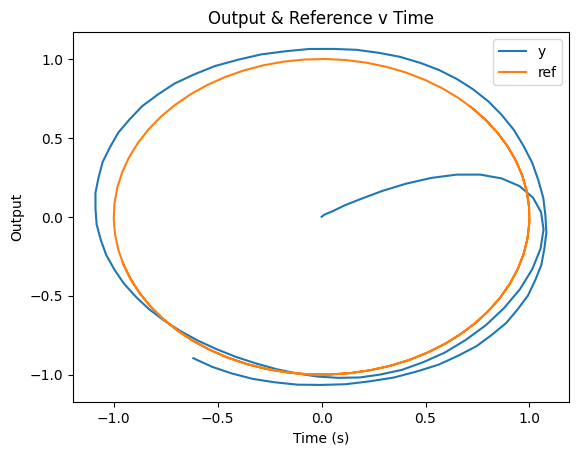

In [100]:
#make figure 1
plt.figure(1)
plt.plot(x1s, x2s, label="y")
plt.plot(r1s, r2s, label="ref")
plt.title("Output & Reference v Time")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()

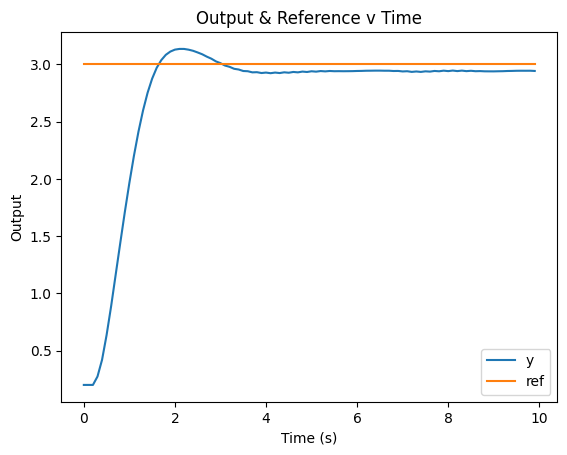

In [101]:
#make figure 1
plt.figure(2)
plt.plot(ts, -x3s, label="y")
plt.plot(ts, -r3s, label="ref")
plt.title("Output & Reference v Time")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()